# Preprocess US federal elections voting data

In [1]:
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Functions

In [2]:
def get_votes_per_year(voting_data, year, threshold=0.5):

    """
    Retrieves voting data for a specified year and calculates various voting metrics.

    Parameters:
    - voting_data: DataFrame containing voting data.
    - year: Year for which voting data is to be retrieved.
    - threshold: Threshold value for classifying counties into voting clusters. Default is 0.5.

    Returns:
    - votes_per_year: DataFrame containing voting metrics for the specified year.
    """
    
    # Filter voting data for the specified year
    voting_data_year_filtered = voting_data[voting_data['year'] == year]
    
    # Aggregate voting data by state
    state_votes = voting_data_year_filtered.groupby(['state','party']).sum().reset_index()
    DEMOCRAT_votes = []
    REPUBLICAN_votes = []
    TOTAL_votes = []

    for cid in voting_data_year_filtered['state'].dropna().unique():
        rows = state_votes[state_votes['state'] == cid]

        dem_votes = np.sum(rows[rows['party'] == 'DEMOCRAT']['candidatevotes'].values)
        rep_votes = np.sum(rows[rows['party'] == 'REPUBLICAN']['candidatevotes'].values)
        total_votes = dem_votes + rep_votes#rows['totalvotes'].values[0]

        # Handle cases where votes are 0
        if dem_votes == 0:
            print('dems 0')#dem_votes = rows[(rows['party'] == 'DEMOCRAT') & (rows['mode'] == 'TOTAL')]['candidatevotes'].values[0]
        if rep_votes == 0:
            print('reps 0')#rep_votes = rows[(rows['party'] == 'REPUBLICAN') & (rows['mode'] == 'TOTAL')]['candidatevotes'].values[0]
    
        DEMOCRAT_votes.append(dem_votes)
        REPUBLICAN_votes.append(rep_votes)
        TOTAL_votes.append(total_votes)

    votes_per_year = pd.DataFrame({
        'state': [(el) for el in voting_data_year_filtered['state'].dropna().unique()],
        'dem_votes_'+str(year): DEMOCRAT_votes,
        'rep_votes_'+str(year): REPUBLICAN_votes,
        'total_votes_'+str(year): TOTAL_votes
    })

    # Calculate vote shares for each party
    votes_per_year['vote_share_rep_'+str(year)] = votes_per_year['rep_votes_'+str(year)] / votes_per_year['total_votes_'+str(year)]
    votes_per_year['vote_share_dem_'+str(year)] = votes_per_year['dem_votes_'+str(year)] / votes_per_year['total_votes_'+str(year)]
    # votes_per_year['vote_share_other_'+str(year)] = votes_per_year['other_votes_'+str(year)] / votes_per_year['total_votes_'+str(year)]
    votes_per_year['voting_cluster_'+str(year)] = np.where((votes_per_year['vote_share_rep_'+str(year)] > threshold),
                                                            'Republicans',
                                                            np.where((votes_per_year['vote_share_dem_'+str(year)] > threshold),
                                                                    'Democrats',
                                                                    'Swing_State'
                                                                    )
                                                            )
    return votes_per_year




In [3]:
def classify_party(df, year, swing_states=[]):
    """
    Classify each row as 'Republican' or 'Democrat' based on the vote shares in the specified year.
    
    Parameters:
        df (DataFrame): The input DataFrame containing vote share columns for different years.
        year (int): The year to base the classification on.
        
    Returns:
        DataFrame: The input DataFrame with an additional column 'party_classification' indicating whether each row is classified as 'Republican' or 'Democrat'.
    """
    party_column = f"political_cluster_{year}"
    df[party_column] = df.apply(lambda row: 'Swing' if row['state'] in [word.upper() for word in swing_states] else ('Republican' if row[f'vote_share_rep_{year}'] > row[f'vote_share_dem_{year}'] else 'Democrat'), axis=1)
    df = df[['state', f'vote_share_rep_{year}', f'vote_share_dem_{year}', party_column]]
    return df

In [4]:
def classify_party_with_threshold(df, year, swing_states=[], swing_threshold=0.1):
    """
    Classify each row as 'Republican', 'Democrat', or 'Swing' based on the vote shares in the specified year.

    Parameters:
        df (DataFrame): The input DataFrame containing vote share columns for different years.
        year (int): The year to base the classification on.
        swing_states (list): A list of states to consider as swing states.
        swing_threshold (float): The threshold percentage difference between vote shares to classify a state as a swing state.

    Returns:
        DataFrame: The input DataFrame with an additional column 'party_classification' indicating whether each row is classified as 'Republican', 'Democrat', or 'Swing'.
    """
    party_column = f"political_cluster_{year}"
    
    # Define a function to classify each row
    def classify_row(row):
        if row['state'] in [word.upper() for word in swing_states]:
            return 'Swing'  # If the state is in the swing states list, classify it as 'Swing'
        vote_share_diff = row[f'vote_share_rep_{year}'] - row[f'vote_share_dem_{year}']
        if abs(vote_share_diff) <= swing_threshold:
            return 'Swing'  # If the difference in vote shares is within the swing threshold, classify it as 'Swing'
        elif vote_share_diff > 0:
            return 'Republican'  # If Republican vote share is greater, classify as 'Republican'
        else:
            return 'Democrat'  # Otherwise, classify as 'Democrat'

    # Apply the classification function to each row
    df[party_column] = df.apply(classify_row, axis=1)
    
    # Reorder and select columns of interest
    df = df[['state', f'vote_share_rep_{year}', f'vote_share_dem_{year}', party_column]]
    
    return df


# Load the voting data

In [5]:
state_data = gpd.read_file("../../../data/utils/US_states_data/us_states_based_on_counties.shp", index_col = 0)

c:\Users\DorianArifi\anaconda3\envs\geo_env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option INDEX_COL
  return ogr_read(


In [6]:
# Source: Voting data: 
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ
voting_data = pd.read_csv('../../../data/voting_data/voting_data.csv')

In [7]:
voting_data

,Unnamed: 0,year,state,state_po,county_name,county_fips,office,candidate,party,candidatevotes,totalvotes,version,mode
0,0,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,AL GORE,DEMOCRAT,4942,17208,20220315,TOTAL
1,1,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,GEORGE W. BUSH,REPUBLICAN,11993,17208,20220315,TOTAL
2,2,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,RALPH NADER,GREEN,160,17208,20220315,TOTAL
3,3,2000,ALABAMA,AL,AUTAUGA,1001.0,US PRESIDENT,OTHER,OTHER,113,17208,20220315,TOTAL
4,4,2000,ALABAMA,AL,BALDWIN,1003.0,US PRESIDENT,AL GORE,DEMOCRAT,13997,56480,20220315,TOTAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72612,72612,2020,WYOMING,WY,WASHAKIE,56043.0,US PRESIDENT,DONALD J TRUMP,REPUBLICAN,3245,4032,20220315,TOTAL
72613,72613,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JOSEPH R BIDEN JR,DEMOCRAT,360,3560,20220315,TOTAL
72614,72614,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,JO JORGENSEN,LIBERTARIAN,46,3560,20220315,TOTAL
72615,72615,2020,WYOMING,WY,WESTON,56045.0,US PRESIDENT,OTHER,OTHER,47,3560,20220315,TOTAL


# Swing County Definition based on historic election outcomes (last six elections)

## Add voting data for each year to the counties

In [8]:
# Initialize merged_dataframe if it doesn't exist
votes_over_time = None
years = [2000, 2004, 2008, 2012, 2016, 2020]

# Loop through years and add votes to the merged_dataframe
for year in years:
    votes_per_year = get_votes_per_year(voting_data, year)
    if votes_over_time is None:
        votes_over_time = votes_per_year
    else:
        votes_over_time = pd.merge(votes_over_time, votes_per_year, on='state', how='left')

## Get the election winner per state 

In [9]:
#classified_df = classify_party(votes_over_time, 2020, swing_states= swing_states)

In [10]:
# Defined solely on the basis of voteshare differences
classified_df = classify_party_with_threshold(round(votes_over_time,2), 2020, swing_states=[], swing_threshold=0.10)

## Categorize each State into Republicans, Democrats, Swing_State

In [11]:
classified_df['political_cluster_2020'].value_counts()

political_cluster_2020
Republican    20
Democrat      17
Swing         14
Name: count, dtype: int64

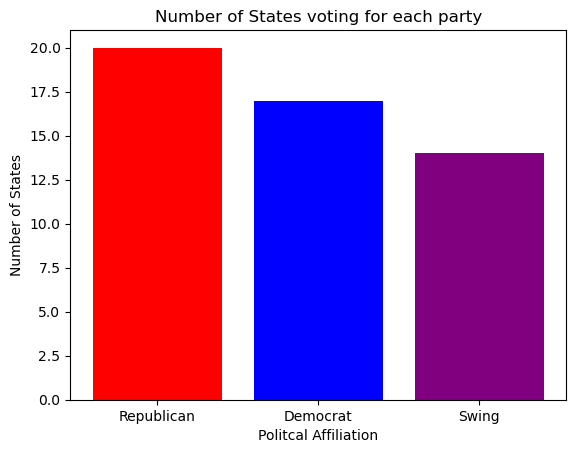

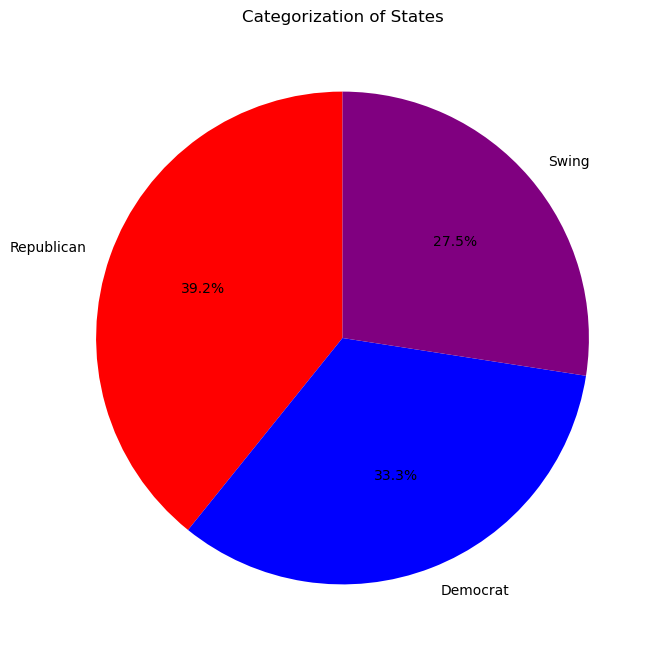

In [12]:
# Plot Bar Chart
category_counts = classified_df['political_cluster_2020'].value_counts()
colors = {'Republican': 'red', 'Democrat': 'blue', 'Swing': 'purple'}
plt.bar(category_counts.index, category_counts.values, color=[colors[politcal_cluster_2020] for politcal_cluster_2020 in category_counts.index])
plt.xlabel('Politcal Affiliation')
plt.ylabel('Number of States')
plt.title('Number of States voting for each party')
plt.show()

# Plot Pie Chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors=[colors[politcal_cluster_2020] for politcal_cluster_2020 in category_counts.index], startangle=90)
plt.title('Categorization of States')
plt.show()

## Merge county geometries with county categories

In [13]:
# Merge the DataFrames on 'countyfips'
state_data.columns = [el.lower() for el in state_data.columns]
state_data.state = [el.lower() for el in state_data.state]
classified_df.state = [el.lower() for el in classified_df.state]
merged_data = pd.merge(state_data, classified_df, on='state',  how='left')

# Convert the DataFrame to GeoDataFrame
geo_df = gpd.GeoDataFrame(merged_data, geometry='geometry')


In [14]:
geo_df['political_cluster_2020'].value_counts()

political_cluster_2020
Republican    20
Democrat      17
Swing         14
Name: count, dtype: int64

In [15]:
geo_df.columns

Index(['state_id', 'state', 'state_shor', 'population', 'geometry',
       'vote_share_rep_2020', 'vote_share_dem_2020', 'political_cluster_2020'],
      dtype='object')

In [16]:

#geo_df.columns = ['population', 'state', 'geometry','Clusters']
#geo_df.dropna(subset=['political_cluster_2020'], axis=0).to_file("../../../data/utils/state_data_political_clusters.shp", index_col = 0)
geo_df.to_csv("../../../data/voting_data/votes_per_state.csv")
geo_df.to_file("../../../data/voting_data/votes_per_state.shp")

C:\Users\DorianArifi\AppData\Local\Temp\ipykernel_40052\1827270247.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geo_df.to_file("../../../data/voting_data/votes_per_state.shp")
c:\Users\DorianArifi\anaconda3\envs\geo_env\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'vote_share_rep_2020' to 'vote_share'
  ogr_write(
c:\Users\DorianArifi\anaconda3\envs\geo_env\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'vote_share_dem_2020' to 'vote_sha_1'
  ogr_write(
c:\Users\DorianArifi\anaconda3\envs\geo_env\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'political_cluster_2020' to 'political_'
  ogr_write(


# Plot voting data on a US map

In [17]:
import geopandas as gpd
from tqdm import tqdm
import contextily as ctx
import matplotlib.patheffects as pe
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [18]:
def plot_map_corr(gdf_map_filtered,  color_dict, states_to_exclude=['ny']):
    # Plot the map
    crs = 3857#4326
    gdf_map_filtered = gdf_map_filtered.to_crs(epsg=crs)

    fig, ax = plt.subplots(1, 1, figsize=(32, 12))

    basemap = ctx.providers.CartoDB.PositronNoLabels
    
    # xmin, ymin, xmax, ymax = gdf_map_filtered.total_bounds

    # Iterate over topics and plot
    data_to_annotate_on_map = pd.DataFrame()
    data_to_plot_hatched = pd.DataFrame()

    colors = []
    # Iterate over each row (state) in the GeoDataFrame
    for idx, row in gdf_map_filtered.iterrows():
        topic = row['political_cluster_2020']
        colors.append(color_dict.get(topic, 'gray'))  # Get color from color_dict, default to gray if not found

        if row['state_shor'] not in states_to_exclude:
            data_to_annotate_on_map = pd.concat([data_to_annotate_on_map, pd.DataFrame(row).transpose()])
       
        # Plot the state
    gdf_map_filtered.plot(ax=ax, color=colors, linewidth=1.2, edgecolor='black')

    # Annotate correlation values
    for idx, row in data_to_annotate_on_map.iterrows():
        centroid = row.geometry.centroid
        state_name = row['state_shor'].upper()
        ax.annotate(f'{state_name}', (centroid.x, centroid.y), fontsize=18, fontweight='bold',  ha='center', va='center',color='white',path_effects=[pe.withStroke(linewidth=4, foreground="black")]) #fontweight='bold',

    # anotate corr values in seperate table for those states were they do not fit on the table
    data_to_plot_in_table = gdf_map_filtered[gdf_map_filtered['state_shor'].isin(states_to_exclude)]
    c=0
    c2=0
    for idx, row in data_to_plot_in_table.iterrows():
        centroid = row.geometry.centroid
        state_name = (row.state_shor).upper()
        text_x, text_y = 0.91, 0.6 - c  # Text annotation coordinates in axes coordinates
        ax.text(text_x, text_y, f'{state_name}', transform=ax.transAxes, fontsize=18, fontweight='bold',color='white', path_effects=[pe.withStroke(linewidth=4, foreground="black")], verticalalignment='center')
        # Transform axes coordinates to data coordinates for the text annotation
        # Draw line from text annotation to centroid
        p1 = -7800000#text_x_data # horizontal movement  
        p2 =  5000000 ## for the up and down movement
        x = centroid.x
        y = centroid.y
        ax.plot([p1, x], [p2-c2, y],  color='black',linewidth=0.5, transform=ax.transData)
        c += 0.03
        c2+= 125000 # Increment c for the next iteration
        
    # Add title and labels
    #plt.title(  ' for Social Media Posts and COVID-19 Cases \n Temporal Lag between '  , size=24)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Create a legend for the colors
    # Replace the value for the key 'R^2<0.5' with the hatch effect
    # try:
    #     color_dict.pop('R^2<0.5', None)
    # except:
    #     pass

    # Create a legend for the colors and hatch effect
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=topic, markerfacecolor=color_dict.get(topic, 'grey'), markersize=16) for topic in list(color_dict.keys())]

    # plt.legend(handles=legend_handles, title='Politcal cluster ', loc='lower right')
    # Increase the font size of the legend text and handle length
    plt.legend(handles=legend_handles, title='Politcal clusters', loc='lower right', fontsize=14, handlelength=3.0, title_fontsize=14)

    # Access the legend properties and increase the size of the legend box
    # plt.legend()

    # Define scale bar parameters
    scale_length = 500  # Length of the scale bar in data units
    scale_unit = 'km'   # Units of the scale bar
    scale_position = 'lower left'  # Position of the scale bar
    scale_fraction = 0.06  # Fraction of the axis to place the scale bar

    # Get axis limits
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    # Calculate scale bar position
    scale_x = x_min + (x_max - x_min) * scale_fraction
    scale_y = y_min + (y_max - y_min) * scale_fraction

    # Plot scale bar as a rectangle
    
    # scalebar = Rectangle((scale_x, scale_y), scale_length*1000, 0.01 * (y_max - y_min), facecolor='black', edgecolor='black')
    # ax.add_patch(scalebar)

    # # # Add North Star above the scale bar
    # location = scale_x + scale_length*1000 / 2, scale_y - 0.001 * (y_max - y_min)+370000
    # print(scale_y - 0.001 * (y_max - y_min))
    # ax.annotate('N', xy=location, xytext=(location[0], location[1] - 240000),
    #             arrowprops=dict(facecolor='black', shrink=5,width=5, headwidth=15, headlength=20),
    #             ha='center', va='center', fontsize=37, color='black')

    # # Add scale bar label
    # scale_label = f'{scale_length} {scale_unit}'
    # ax.text(scale_x + scale_length*1000 / 2, scale_y - 0.01 * (y_max - y_min), scale_label, ha='center', va='top')
    # ctx.add_basemap(ax, crs=crs, source=basemap, alpha=0.5)

    scalebar = AnchoredSizeBar(
        ax.transData,
        100*10**3*5,           # Length in data units
        '500 km',              # Label
        'lower left',           # Location
        pad=1,
        color='black',
        frameon=False,
        size_vertical=50000,        # Thickness of the scalebar line
        fontproperties=fm.FontProperties(size=16),
        fill_bar=True  # Font size of the label
    )

    ax.add_artist(scalebar)

   # Estimate position based on axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # You can fine-tune these offsets based on your specific plot size and projection
    x_pos = xlim[0] + 0.05 * (xlim[1] - xlim[0])     # 5% from left
    y_pos = ylim[0] + 0.08 * (ylim[1] - ylim[0])     # Adjust height to be just above scalebar

    # Annotate the North arrow
    ax.annotate('N',
        xy=(x_pos, y_pos+ 280000),                         # Arrow tip
        xytext=(x_pos, y_pos + 80000),            # Start of arrow
        arrowprops=dict(facecolor='black', width=5, headwidth=10, headlength=18),
        ha='center', va='center',
        fontsize=32, color='black'
    )


    # Remove latitude and longitude values
    ax.set_axis_off()

    ctx.add_basemap(ax, crs=crs, source=basemap, alpha=0.5)
    # Add a border/frame around the basemap
    border_color = 'black'
    border_width = 3
    rect = Rectangle(
        (0, 0), 1, 1, transform=ax.transAxes, 
        linewidth=border_width, edgecolor=border_color, facecolor='none'
    )
    ax.add_patch(rect)
    # plt.savefig(r"C:\Users\b1066706\OneDrive - Universität Salzburg\Documents\PHD\4. Research\1. Paper\2_US_Early_warning_different_topics\Submission\Figures\Fig1_300dpi.png", dpi=300, bbox_inches='tight')
    plt.show()
# plot_map_corr(geo_df_plot,  color_dict=colors, states_to_exclude=['nh','ri','ct','de', 'dc'])


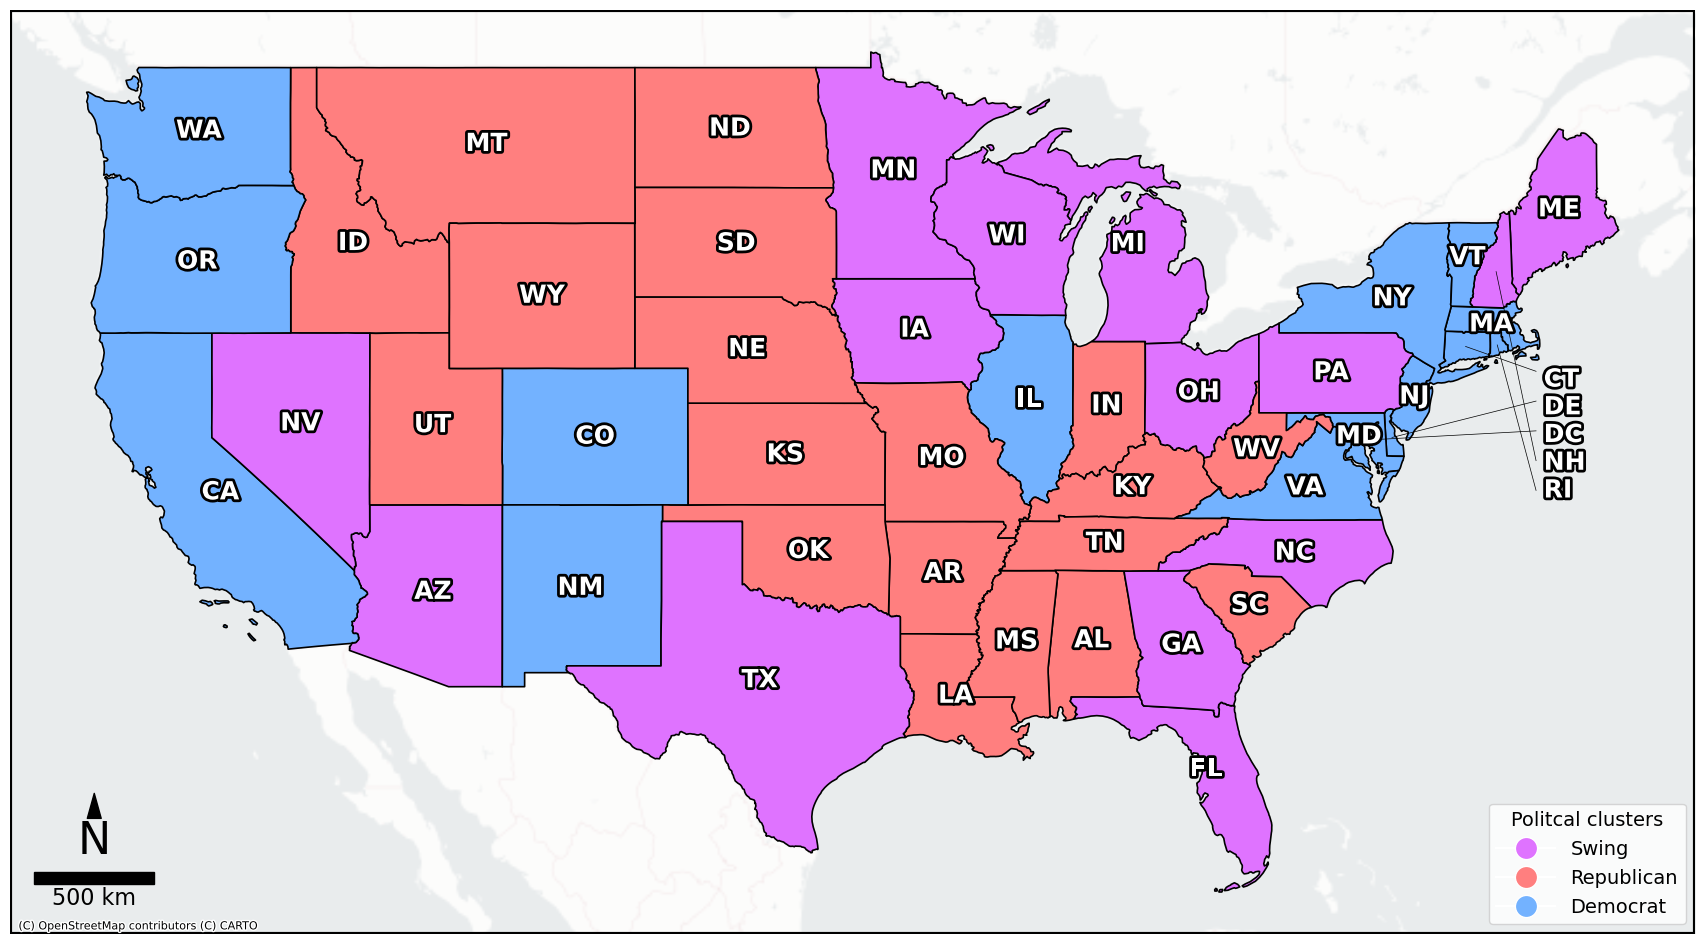

In [20]:
colors = {'Swing': '#df73ff', 'Republican': '#ff7f7f', 'Democrat': '#73b2ff'}

geo_df_plot = geo_df[geo_df['state'].isin(['alaska','hawaii'])==False]

plot_map_corr(geo_df_plot,  color_dict=colors, states_to_exclude=['nh','ri','ct','de', 'dc'])